# ANN, excluding Cys-epitopes

In [2]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

2025-04-01 15:45:36.788560: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-01 15:45:36.795150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743536736.803431   90172 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743536736.806129   90172 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 15:45:36.814354: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## dataset

In [2]:
infile = '/home/yuan/results/epitope/epi_top_features.txt'
df = pd.read_csv(infile, sep='\t', header=0, index_col=None)
# balance the number of epitopes and non-epitopes
# shuffle rows
df = df.sample(frac=1)
df.head()

,seq,label,mean_hydro_ph7,mean_hydro,mean_polar,mean_polar_stab,mean_VDWV,median_hydro_ph7,median_hydro,median_polar,...,has_N,has_D,has_C,has_I,has_L,has_K,has_F,has_T,has_Y,has_V
876310,NQHSNASQS,0,-4.666667,0.165556,10.033333,0.121111,2.695556,-5.0,0.05,10.4,...,1,0,0,0,0,0,0,0,0,0
679294,VSKLEESSK,0,5.555556,0.693333,9.511111,0.139111,3.211111,-5.0,0.47,9.2,...,0,0,0,0,1,1,0,0,0,1
2127117,LHIMKCNLG,0,41.444444,1.046667,7.611111,0.165556,3.471111,49.0,1.15,5.7,...,1,0,1,1,1,1,0,0,0,0
2223042,LSVVTGLQEVTRTIE,1,31.266667,0.736667,8.153333,0.142467,3.202667,13.0,0.47,8.6,...,0,0,0,1,1,0,0,1,0,1
1785125,LVAAVCLGLNLIF,0,64.769231,1.186154,6.469231,0.142615,3.020769,76.0,1.32,5.5,...,1,0,1,1,1,0,1,0,0,1


In [4]:
%load_ext autoreload
%autoreload 2

from seq.my_ann import MyAnn
from seq.compare_model import CompareModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## filter I: without Cys

In [5]:
# keep epitopes without Cys
feature = 'has_C'
print('entire data:', df.shape)
print('epitopes without Cys:', df[(df[feature]==0) & (df['label']==1)].shape)
print('epitopes having Cys:', df[(df[feature]==1) & (df['label']==1)].shape)
sub_df = df[~((df[feature]==1) & (df['label']==1))]
print('filtered data:', sub_df.shape)

entire data: (2490831, 48)
epitopes without Cys: (1586519, 48)
epitopes having Cys: (212276, 48)
filtered data: (2278555, 48)


In [6]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (2278555, 46) float16
y: (2278555,) float16
labels: Counter({np.float16(1.0): 1586519, np.float16(0.0): 692036})
train data: (1275990, 46) (1275990,)
validate data: (546854, 46) (546854,)
test data (455711, 46) (455711,)


In [7]:
# train model
c.declare_model()
c.train(epochs=10)

I0000 00:00:1743532542.632773   77890 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1227 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        24,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,409 (286.75 KB)

 Trainable params: 73,409 (286.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


I0000 00:00:1743532543.955413   79349 service.cc:148] XLA service 0x7a4a1c016e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743532543.955445   79349 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-04-01 14:35:43.978569: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743532544.057976   79349 cuda_dnn.cc:529] Loaded cuDNN version 90800


  132/39875 ━━━━━━━━━━━━━━━━━━━━ 45s 1ms/step - accuracy: 0.7411 - auc: 0.6952 - loss: 0.5487 - mse: 0.1822 - precision: 0.7714 - recall: 0.8943

I0000 00:00:1743532544.666048   79349 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


39875/39875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7781 - auc: 0.7659 - loss: 0.4813 - mse: 0.1578 - precision: 0.7725 - recall: 0.9661

E0000 00:00:1743532591.468770   79345 buffer_comparator.cc:157] Difference at 16: 0, expected 260.803
E0000 00:00:1743532591.468795   79345 buffer_comparator.cc:157] Difference at 17: 0, expected 274.951
E0000 00:00:1743532591.468798   79345 buffer_comparator.cc:157] Difference at 18: 0, expected 253.659
E0000 00:00:1743532591.468799   79345 buffer_comparator.cc:157] Difference at 19: 0, expected 257.607
E0000 00:00:1743532591.468800   79345 buffer_comparator.cc:157] Difference at 20: 0, expected 250.262
E0000 00:00:1743532591.468802   79345 buffer_comparator.cc:157] Difference at 21: 0, expected 258.782
E0000 00:00:1743532591.468803   79345 buffer_comparator.cc:157] Difference at 22: 0, expected 253.591
E0000 00:00:1743532591.468804   79345 buffer_comparator.cc:157] Difference at 23: 0, expected 258.759
E0000 00:00:1743532591.468805   79345 buffer_comparator.cc:157] Difference at 24: 0, expected 259.406
E0000 00:00:1743532591.468806   79345 buffer_comparator.cc:157] Difference at 25: 

39875/39875 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - accuracy: 0.7781 - auc: 0.7659 - loss: 0.4813 - mse: 0.1578 - precision: 0.7725 - recall: 0.9661 - val_accuracy: 0.7851 - val_auc: 0.7847 - val_loss: 0.4743 - val_mse: 0.1541 - val_precision: 0.7794 - val_recall: 0.9641
Epoch 2/10
39875/39875 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - accuracy: 0.7852 - auc: 0.7870 - loss: 0.4676 - mse: 0.1524 - precision: 0.7814 - recall: 0.9600 - val_accuracy: 0.7860 - val_auc: 0.7923 - val_loss: 0.4655 - val_mse: 0.1517 - val_precision: 0.7775 - val_recall: 0.9703
Epoch 3/10
39875/39875 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - accuracy: 0.7886 - auc: 0.7936 - loss: 0.4626 - mse: 0.1504 - precision: 0.7864 - recall: 0.9557 - val_accuracy: 0.7880 - val_auc: 0.7954 - val_loss: 0.4626 - val_mse: 0.1505 - val_precision: 0.7919 - val_recall: 0.9433
Epoch 4/10
39875/39875 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - accuracy: 0.7905 - auc: 0.7968 - loss: 0.4596 - mse: 0.1492 - precision: 0.7894 - recall: 0.9535 - val_accuracy: 0.

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.780311,0.774252,0.476174,0.155811,0.774768,0.965072,0.785116,0.784721,0.474338,0.154100,0.779409,0.964114
1,0.786249,0.788840,0.466098,0.151782,0.782974,0.958807,0.786040,0.792312,0.465498,0.151671,0.777474,0.970286
2,0.789469,0.795160,0.461192,0.149824,0.787483,0.955539,0.788033,0.795405,0.462550,0.150511,0.791910,0.943313
3,0.790261,0.798069,0.458993,0.149007,0.789408,0.953052,0.790571,0.797053,0.459662,0.149310,0.797186,0.937629
4,0.790998,0.799765,0.457520,0.148463,0.790621,0.951972,0.790085,0.798151,0.462729,0.149678,0.795494,0.940057
5,0.791464,0.800846,0.456757,0.148164,0.791319,0.951440,0.790657,0.797920,0.464177,0.149691,0.789390,0.953641
6,0.791693,0.801797,0.456079,0.147898,0.791533,0.951444,0.790092,0.799512,0.465802,0.150242,0.782567,0.967102
7,0.791835,0.802574,0.455447,0.147660,0.792083,0.950589,0.791515,0.798288,0.461247,0.149260,0.791335,0.951282
8,0.791983,0.802874,0.455260,0.147600,0.792166,0.950707,0.790900,0.801024,0.457938,0.148576,0.784741,0.963985
9,0.792352,0.803325,0.454817,0.147469,0.792477,0.950787,0.791006,0.800635,0.456117,0.148047,0.791066,0.950846


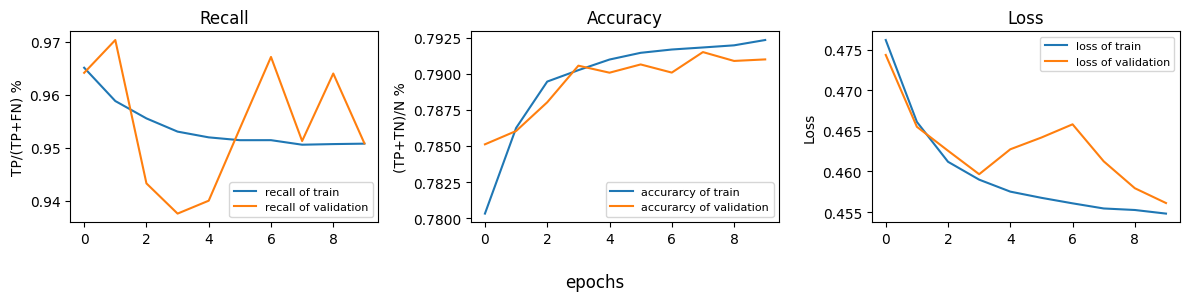

In [8]:
# evaluate model
c.plot_acc_recall()

14214/14241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7908 - auc: 0.7982 - loss: 0.4580 - mse: 0.1486 - precision: 0.7910 - recall: 0.9508

E0000 00:00:1743533181.698481   79347 buffer_comparator.cc:157] Difference at 16: -0.652344, expected 265.631
E0000 00:00:1743533181.698506   79347 buffer_comparator.cc:157] Difference at 17: 0.511719, expected 254.291
E0000 00:00:1743533181.698509   79347 buffer_comparator.cc:157] Difference at 18: -0.295166, expected 262.208
E0000 00:00:1743533181.698510   79347 buffer_comparator.cc:157] Difference at 19: -0.784668, expected 258.587
E0000 00:00:1743533181.698511   79347 buffer_comparator.cc:157] Difference at 20: 1.21582, expected 251.99
E0000 00:00:1743533181.698513   79347 buffer_comparator.cc:157] Difference at 21: -0.579102, expected 252.063
E0000 00:00:1743533181.698514   79347 buffer_comparator.cc:157] Difference at 22: 1.06152, expected 250.726
E0000 00:00:1743533181.698516   79347 buffer_comparator.cc:157] Difference at 23: 0.871094, expected 249.962
E0000 00:00:1743533181.698518   79347 buffer_comparator.cc:157] Difference at 24: -0.76123, expected 250.175
E0000 00:00:174353

14241/14241 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.7908 - auc: 0.7982 - loss: 0.4580 - mse: 0.1486 - precision: 0.7910 - recall: 0.9508
{'accuracy': 0.7905909419059753, 'auc': 0.7988219857215881, 'loss': 0.45759254693984985, 'mse': 0.14846327900886536, 'precision': 0.7908647656440735, 'recall': 0.9507277011871338}
14241/14241 ━━━━━━━━━━━━━━━━━━━━ 8s 542us/step
[[0.5587899]
 [0.5663523]
 [0.8441808]]


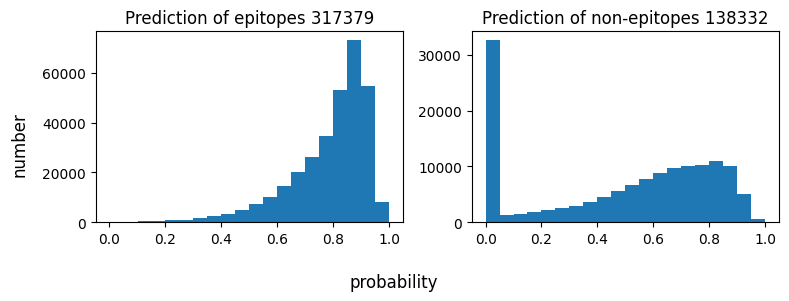

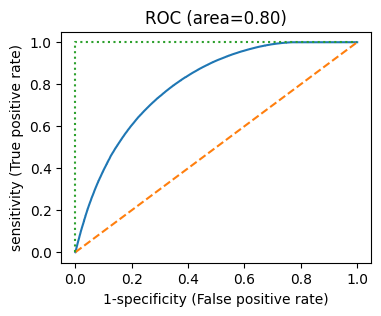

In [9]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [10]:
# save entire model
c.save_model('../models/epitopes_ann_notCys.keras')

<Sequential name=sequential, built=True>

## filter II: having Cys

In [11]:
# keep epitopes container Cys
feature = 'has_C'
print('entire data:', df.shape)
print('epitopes without Cys:', df[(df[feature]==0) & (df['label']==1)].shape)
print('epitopes having Cys:', df[(df[feature]==1) & (df['label']==1)].shape)
sub_df = df[~((df[feature]==0) & (df['label']==1))]
print('filtered data:', sub_df.shape)

entire data: (2490831, 48)
epitopes without Cys: (1586519, 48)
epitopes having Cys: (212276, 48)
filtered data: (904312, 48)


In [12]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (904312, 46) float16
y: (904312,) float16
labels: Counter({np.float16(0.0): 692036, np.float16(1.0): 212276})
train data: (506414, 46) (506414,)
validate data: (217035, 46) (217035,)
test data (180863, 46) (180863,)


In [13]:
# train model
c.declare_model()
c.train(epochs=10)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │        24,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,409 (286.75 KB)

 Trainable params: 73,409 (286.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
15826/15826 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8784 - auc: 0.9430 - loss: 0.2422 - mse: 0.0815 - precision: 0.7260 - recall: 0.7726

E0000 00:00:1743533452.732702   79349 buffer_comparator.cc:157] Difference at 16: -0.72456, expected 257.24
E0000 00:00:1743533452.732726   79349 buffer_comparator.cc:157] Difference at 17: -0.745128, expected 274.987
E0000 00:00:1743533452.732729   79349 buffer_comparator.cc:157] Difference at 18: -0.839415, expected 263.762
E0000 00:00:1743533452.732730   79349 buffer_comparator.cc:157] Difference at 19: -0.596485, expected 259.318
E0000 00:00:1743533452.732732   79349 buffer_comparator.cc:157] Difference at 20: -0.524697, expected 255.429
E0000 00:00:1743533452.732733   79349 buffer_comparator.cc:157] Difference at 21: -1.34029, expected 257.289
E0000 00:00:1743533452.732734   79349 buffer_comparator.cc:157] Difference at 22: -1.39324, expected 252.845
E0000 00:00:1743533452.732737   79349 buffer_comparator.cc:157] Difference at 23: -1.86706, expected 255.447
E0000 00:00:1743533452.732739   79349 buffer_comparator.cc:157] Difference at 24: -0.839562, expected 254.271
E0000 00:00:174

15826/15826 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.8784 - auc: 0.9430 - loss: 0.2422 - mse: 0.0815 - precision: 0.7260 - recall: 0.7726 - val_accuracy: 0.8935 - val_auc: 0.9535 - val_loss: 0.2233 - val_mse: 0.0742 - val_precision: 0.7422 - val_recall: 0.8363
Epoch 2/10
15826/15826 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.8972 - auc: 0.9536 - loss: 0.2223 - mse: 0.0734 - precision: 0.7697 - recall: 0.8037 - val_accuracy: 0.8970 - val_auc: 0.9546 - val_loss: 0.2206 - val_mse: 0.0727 - val_precision: 0.7793 - val_recall: 0.7825
Epoch 3/10
15826/15826 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.9004 - auc: 0.9556 - loss: 0.2173 - mse: 0.0714 - precision: 0.7757 - recall: 0.8078 - val_accuracy: 0.8972 - val_auc: 0.9545 - val_loss: 0.2238 - val_mse: 0.0735 - val_precision: 0.7761 - val_recall: 0.7896
Epoch 4/10
15826/15826 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9013 - auc: 0.9561 - loss: 0.2163 - mse: 0.0710 - precision: 0.7741 - recall: 0.8171 - val_accuracy: 0.

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.887888,0.948908,0.231441,0.077379,0.746199,0.791204,0.893473,0.953467,0.223337,0.074159,0.742175,0.836258
1,0.897671,0.953910,0.221238,0.073015,0.769085,0.805707,0.897026,0.954554,0.220631,0.072735,0.779324,0.782463
2,0.900153,0.955484,0.217705,0.071576,0.774375,0.810539,0.897219,0.954513,0.223835,0.073491,0.776051,0.789575
3,0.901972,0.956770,0.215039,0.070477,0.775915,0.818519,0.899975,0.955091,0.220396,0.072453,0.770490,0.816767
4,0.903857,0.957814,0.212656,0.069470,0.778678,0.824520,0.902334,0.956608,0.215961,0.071001,0.766062,0.840069
5,0.904813,0.958546,0.211131,0.068859,0.780010,0.827677,0.902587,0.956825,0.215107,0.070372,0.780459,0.813427
6,0.905927,0.959170,0.209756,0.068262,0.781826,0.830842,0.901223,0.956339,0.215964,0.071082,0.758962,0.848164
7,0.906422,0.959730,0.208498,0.067802,0.782009,0.833426,0.903375,0.956307,0.216468,0.070646,0.775602,0.827338
8,0.907246,0.960205,0.207562,0.067412,0.784472,0.833653,0.905937,0.958798,0.210467,0.068421,0.785369,0.824115
9,0.907449,0.960664,0.206613,0.067056,0.783713,0.836271,0.905983,0.958604,0.213332,0.069207,0.791600,0.813172


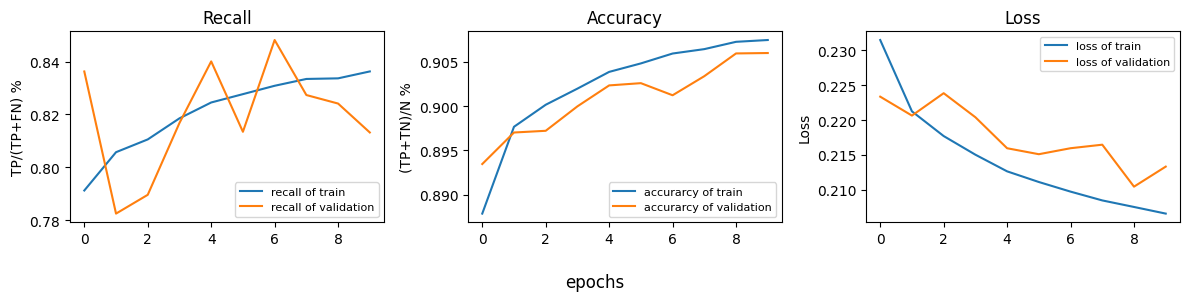

In [14]:
# evaluate model
c.plot_acc_recall()

5652/5652 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9054 - auc: 0.9589 - loss: 0.2132 - mse: 0.0692 - precision: 0.7903 - recall: 0.8140
{'accuracy': 0.9057573676109314, 'auc': 0.9588344097137451, 'loss': 0.21340420842170715, 'mse': 0.06914544850587845, 'precision': 0.7915905117988586, 'recall': 0.8139927983283997}
5652/5652 ━━━━━━━━━━━━━━━━━━━━ 3s 518us/step
[[9.406888e-02]
 [5.549013e-01]
 [7.142708e-36]]


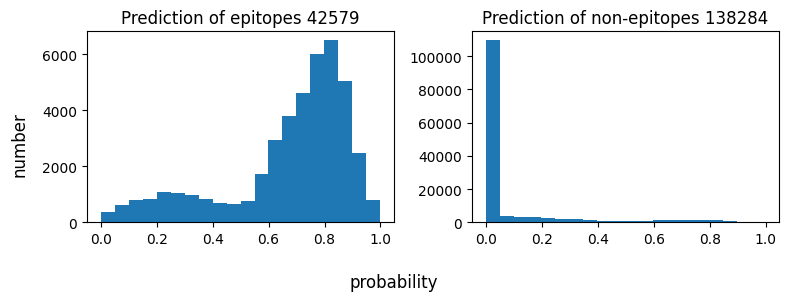

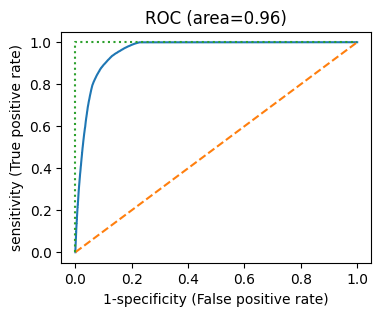

In [15]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [16]:
# save entire model
c.save_model('../models/epitopes_ann_hasCys.keras')

<Sequential name=sequential_1, built=True>

## compare

In [3]:
infile = '/home/yuan/results/epitope/epi_top_features.txt'
df = pd.read_csv(infile, sep='\t', header=0, index_col=None)
# balance the number of epitopes and non-epitopes
# shuffle rows
df = df.sample(frac=1)
df.head()

,seq,label,mean_hydro_ph7,mean_hydro,mean_polar,mean_polar_stab,mean_VDWV,median_hydro_ph7,median_hydro,median_polar,...,has_N,has_D,has_C,has_I,has_L,has_K,has_F,has_T,has_Y,has_V
56880,DVIAKFAQL,1,40.666667,1.102222,8.022222,0.155333,3.376667,41.0,1.15,8.1,...,0,1,0,1,1,1,1,0,0,1
775989,IGLRKELRLVKEETE,1,18.733333,0.908667,9.080000,0.174400,3.901333,-14.0,0.60,10.5,...,0,0,0,1,1,1,0,1,0,1
136762,RCFGFVSFKEQSAAS,1,27.600000,0.807333,8.293333,0.150467,3.235333,0.0,0.61,9.0,...,0,0,1,0,0,1,1,0,0,1
1731659,FPDQWIKDF,1,23.000000,1.436667,8.533333,0.212778,4.540000,-10.0,1.95,8.0,...,0,1,0,1,0,1,1,0,0,0
308258,GKTFILKTFLPCPAE,1,29.333333,1.189333,7.740000,0.158600,3.411333,13.0,1.15,8.0,...,0,0,1,1,1,1,1,1,0,0


In [4]:
from compare_model import CompareModel
cm = CompareModel('../models')

ModuleNotFoundError: No module named 'compare_model'

In [26]:
# origin ANN model
y1, pred1 = cm.predict_default(df, 'epitopes_ann')

In [ ]:
model1 = tf.keras.models.load_model('../models/epitopes_ann_hasCys.keras')
model2 = tf.keras.models.load_model('../models/epitopes_ann_notCys.keras')


X: (2490831, 46) float16
y: (2490831,) float16
labels: Counter({np.float16(1.0): 1798795, np.float16(0.0): 692036})


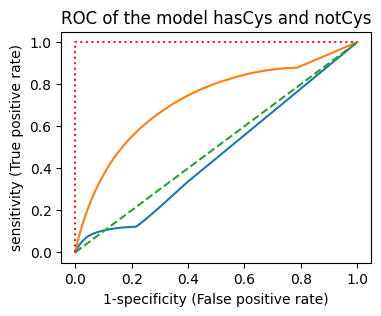

In [23]:
cm.plot_roc('hasCys', 'notCys')